<a href="https://colab.research.google.com/github/Herpsime/gdsc_study_session_ML_g1/blob/main/ride_price_ml/notebook/ride_price_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**problem definition**

This project try to solve the problem of ride price prediction based on different features (which are measurable)

so this use supervised learning a regression to predict the price and classification for predicting whether the ride is high priced or low
the model learns by mapping x which is trip feature to y the ride price

**Why ML instead of fixed rules?**

It is because the fixed formula would require manually encoding all the relationships as a result it doesn't capture complex interaction between features and the price, It can't adapt dynamically to changing patterns,also can't learn from historical pricing behavior therefore this system is impractical and regid

while ML allows system to learn patterns from data and it starts discovering relationships between features and price  


**What the model is expected to learn**

the regression model is expected to learn how much each feature contributed to ride price and
patterns in how ride prices increases or decreases under different conditions

the classification model is expected to learnthe probability of the ride price be high or low and a decision boundary between expensive and affordable

**Dataset justification**

i created my own dataset with 150 rows 6 features which are both categorical and numerical features and 1 target variable which is ride price i used Feres ride app for the research

*features i used*


*  Distance (km) -> Longer trips cost more.

* Trip Duration (minutes) -> More time increases cost.

* Traffic Level -> High traffic increases time and fuel use.

* Demand Level -> High demand can increase price.

* Fuel price -> High fuel cost increase the ride price.

* vehicle type -> different type can affect the price.

*feature not incuded*
* pickup/drop off location -> removed it because it need complex encoding and it is also included in distance

*time of day -> it is included with demand level

* weather condition -> it is also can be included in demand level

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score, accuracy_score, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [3]:
from google.colab import files
uploaded = files.upload()

Saving ride.csv to ride.csv


data extraction, exploration and cleaning

In [4]:
data = pd.read_excel('ride.csv')

In [5]:
data.shape


(150, 7)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Distance(km)           150 non-null    float64
 1   Duration(min)          150 non-null    int64  
 2   fuel_price(per liter)  150 non-null    float64
 3   Traffic_level          150 non-null    object 
 4   vehicle_type           150 non-null    object 
 5   Demand_level           150 non-null    object 
 6   ride_price             150 non-null    int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 8.3+ KB


In [7]:
data.describe()

,Distance(km),Duration(min),fuel_price(per liter),ride_price
count,150.000000,150.000000,150.000000,150.000000
mean,8.964000,22.046667,104.234933,448.406667
std,5.573226,9.277480,19.292535,270.735144
min,1.900000,8.000000,74.850000,191.000000
25%,5.500000,15.000000,82.600000,272.500000
50%,7.800000,21.000000,101.470000,360.500000
75%,10.000000,27.000000,122.530000,503.750000
max,32.600000,52.000000,129.120000,1724.000000


In [8]:
data.isnull().sum()

,0
Distance(km),0
Duration(min),0
fuel_price(per liter),0
Traffic_level,0
vehicle_type,0
Demand_level,0
ride_price,0


checkin consistency of categorical value

In [9]:
for col in data.select_dtypes(include="object").columns:
    print(col, data[col].unique())

Traffic_level ['Moderate' 'Free Flow' 'Normal' 'Heavy' 'Gridlock']
vehicle_type ['Economy' 'Basic' 'Luxury' 'basic']
Demand_level ['Medium' 'Low' 'High']


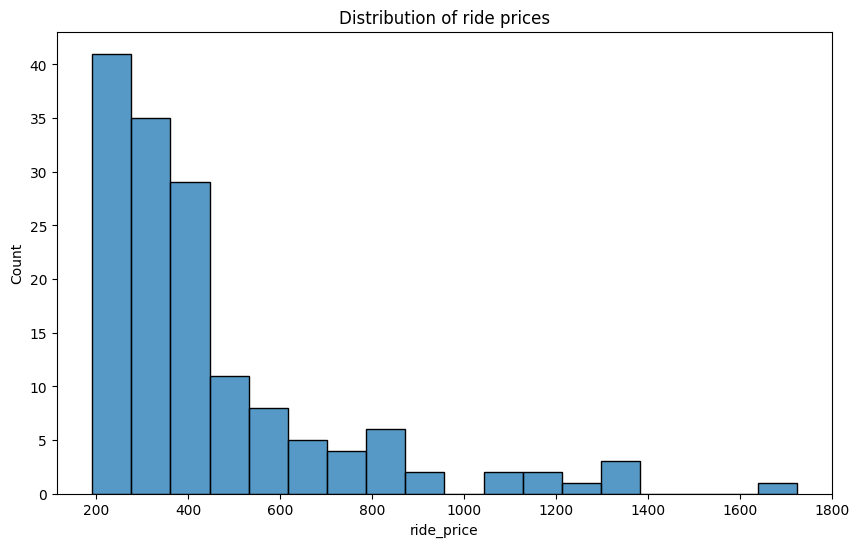

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(data["ride_price"])
plt.title("Distribution of ride prices")
plt.show()

Remove outlier

In [11]:
Q1 = data["ride_price"].quantile(0.25)
Q3 = data["ride_price"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data = data[(data["ride_price"] >= lower_bound) & (data["ride_price"] <= upper_bound)]

In [12]:
data.shape

(137, 7)

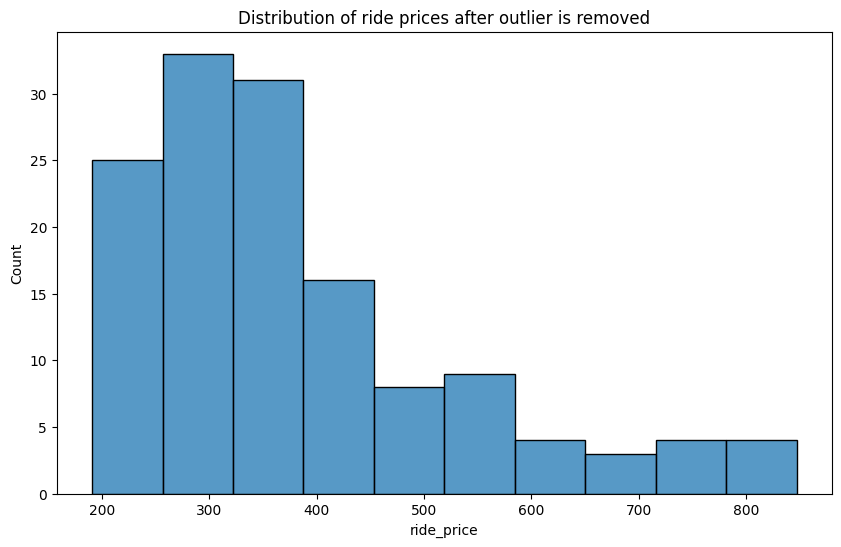

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(data["ride_price"])
plt.title("Distribution of ride prices after outlier is removed")
plt.show()

**how poor data quality could affect model performance**

poor data quality can decrease the ML model performance since it learn the patterns directly from data

these poor quality datas canbe missing value, incorrect data, outlier, imbalanced data, poor feature design and e.t.c

such datas leads to poor generalization, low accuracy, unstable prediction and unreliable results

Regression

In [14]:
x = data.drop("ride_price", axis=1)
y = data["ride_price"]

numeric_features = x.select_dtypes(include="number").columns
categorical_features = x.select_dtypes(include="object").columns

In [15]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=0
)

In [16]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


In [17]:
model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("regressor", LinearRegression()),
    ]
)


model.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['Distance(km)', 'Duration(min)', 'fuel_price(per liter)'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Traffic_level', 'vehicle_type', 'Demand_level'], dtype='object'))])),
                ('regressor', LinearRegression())])

In [18]:
y_pred = model.predict(x_test)

In [19]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)
print("Explained Variance Score:", evs)

Mean Absolute Error (MAE): 24.693911882399956
Mean Squared Error (MSE): 1128.29865409348
Root Mean Squared Error (RMSE): 33.59015710135158
R-squared (R2): 0.921874898892446
Explained Variance Score: 0.9241754422736086


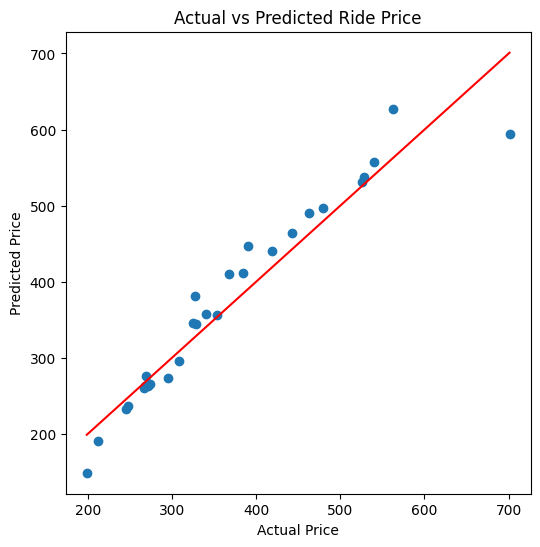

In [20]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Ride Price")

plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red")

plt.show()

I trained a linear reression model to predict the ride price and the model has learned how each feature contributes to price

i've evaluated it using regression metrics and also compared the predicted prive with the actual one

and this model is
0.921874898892446 probability of being right
wich means 92% accurate

Classification

In [21]:
median_price = data["ride_price"].median()
data["high_cost"] = (data["ride_price"] > median_price).astype(int)

In [22]:
x_c = data.drop(["ride_price", "high_cost"], axis=1)
y_c = data["high_cost"]

xc_train, xc_test, yc_train, yc_test = train_test_split(
    x_c, y_c, test_size=0.3, random_state=0
)

In [23]:
numeric_transformer_classification = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),  # Add StandardScaler for numerical features
    ]
)


categorical_transformer_classification = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)


preprocess_classification = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_classification, numeric_features),
        ("cat", categorical_transformer_classification, categorical_features),
    ]
)


xc_train = preprocess_classification.fit_transform(xc_train)
xc_test = preprocess_classification.transform(xc_test)


In [24]:
log_model = LogisticRegression()
log_model.fit(xc_train, yc_train)

LogisticRegression()

In [25]:
yc_pred = log_model.predict(xc_test)

In [26]:
print("Accuracy:", accuracy_score(yc_test, yc_pred))
print("\nConfusion Matrix:\n", confusion_matrix(yc_test, yc_pred))
print("\nClassification Report:\n", classification_report(yc_test, yc_pred))

Accuracy: 0.9047619047619048

Confusion Matrix:
 [[21  3]
 [ 1 17]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.88      0.91        24
           1       0.85      0.94      0.89        18

    accuracy                           0.90        42
   macro avg       0.90      0.91      0.90        42
weighted avg       0.91      0.90      0.91        42



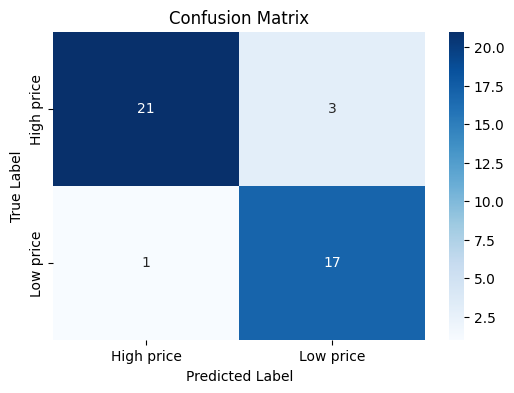

In [27]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(yc_test, yc_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['High price', 'Low price'],
            yticklabels=['High price', 'Low price'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

I've created a new variable so if high_cost = 1 if ride price is high and if high_cost = 0 if ride price is low

Then I trained a Logistic Regression model.

Logistic Regression predicts a probability between 0 and 1.
If the probability is above 0.5, the ride is classified as high-cost.

I've evaluated the model using accuracy, confusion matrix, classification report

also compared the true value with the predicted once by using confusion matrix

In [29]:
feature_names = preprocess_classification.get_feature_names_out()


lin_coefficients = model.named_steps['regressor'].coef_

log_coefficients = log_model.coef_[0]


importance_data = pd.DataFrame({
    "Feature": feature_names,
    "Linear_Regression_Coefficient": lin_coefficients,
    "Logistic_Regression_Coefficient": log_coefficients
})

importance_data["LR_Abs"] = np.abs(importance_data["Linear_Regression_Coefficient"])
importance_data["LogR_Abs"] = np.abs(importance_data["Logistic_Regression_Coefficient"])


importance_data = importance_data.sort_values(by="LR_Abs", ascending=False)

print(importance_data)

                         Feature  Linear_Regression_Coefficient  \
10      cat__vehicle_type_Luxury                     140.006441   
4    cat__Traffic_level_Gridlock                     114.346475   
8        cat__vehicle_type_Basic                     -79.804066   
9      cat__vehicle_type_Economy                     -66.658953   
3   cat__Traffic_level_Free Flow                     -53.325895   
7      cat__Traffic_level_Normal                     -47.854046   
0              num__Distance(km)                      27.793721   
6    cat__Traffic_level_Moderate                     -26.391835   
5       cat__Traffic_level_Heavy                      13.225301   
11       cat__vehicle_type_basic                       6.456578   
12        cat__Demand_level_High                       2.230087   
1             num__Duration(min)                       1.755931   
13         cat__Demand_level_Low                      -1.289224   
14      cat__Demand_level_Medium                      -0.94086

In [30]:
top_feature = importance_data.iloc[0]
print("Most Influential Feature:")
print(top_feature)


Most Influential Feature:
Feature                            cat__vehicle_type_Luxury
Linear_Regression_Coefficient                    140.006441
Logistic_Regression_Coefficient                    2.143682
LR_Abs                                           140.006441
LogR_Abs                                           2.143682
Name: 10, dtype: object


**comparing the two models**

regression gives the exact price and classification gives price category

vehicle type  was the most influential feature

**Ethical and practical reflection**

Real-world risk The model may not perform well if traffic patterns change.

Dataset limitation
The dataset is self made with less research (only based on one app), so it may not fully represent real-world ride data.